# Weekly Report 21/11/2016

## Jupyter

This report looks very different from the reports in the previous weeks.

Following Simon's and John's suggestion I stopped running analyses as a bunch of python & bash scripts (although one bash script still remains) and refactored most of the code into jupyter notebooks. Because jupyter supports markdown, the report itself is also a part of the notebook.

This proved to be more challenging than I thought, but I believe it was a worthwhile effort.

The main difficulty is that various bits of analysis are written in python and R (and a few remaining lines of bash) and I needed a solution, which could run the right bit of analysis in the right time. While jupyter supports both R and python, it doesn't support mixing them within one notebook. A workaround I eventually managed to figure out is to split the analysis into multiple notbooks and execute all "auxiliary" notebooks from a "master" notebook using some internal functionality of jupyter. This may not be ideal, but it's the best I could do.

Other difficulties remain: 

1. The report may be hard to read, because the computation of the results, their description & their presentation are interleaved. 
2. The report will become longer every week. The most relevant bits will live at the end of the notebook.
3. Many small things are not working: installing R packages is awkward, some R functions are not supported, spellcheck doesn't work, R kernel sometimes dies for no reason, code boxes overflow in the pdf version, double quotation marks are broken in the pdf version, etc.

As to the benefits of this approach:

1. Jupyter is interactive, which means I don't have to wait 10 seconds on each execution of each script. This really has big impact on productivity, as each script is executed hundreds of times, i.e. on every small modification of the codebase. Using my workaround we do not lose the batch-processing capability.
2. Jupyter supports markdown cells, which means I can document what I'm doing as I go.
3. Jupyter supports inline plots. This is another productivity gain, as writing pngs to disk (and correctly naming them!) and then manually attaching them to latex files was slow & error-prone.
4. It becomes easier to achieve the solution reached by Simon's former student: each compilation of dissertation leads to a full re-run of all notebooks, which in turn leads to fully reproducible research (how did this student deal with software dependencies though? A docker container could be a way...).

## Are ISEs a failure of normalisation?

I'm trying to validate Darren's concern raised last week (more details at the end of this notebook).

## Ordering genes by their significance

I order genes by their significance using ordinary linear regression and Benjamini–Hochberg procedure in python. I try the same using limma's regression in R, but there are still some problems remaining (more details in notebook analyseLimma.ipynb).

## Disease-Specific effects in python

I compute Disease Specific Effects (DSEs) in python and try to reproduce Wilf's results (more details at the end of this notebook).


# Analysis of microarry data from patients with myotonic dystrophy.

# Pre-process & Normalise data

In [133]:
# First check if all CEL files are present. We expect data from 35 patients

import os, os.path

CEL_LOCATION = os.path.join("CELfiles", "blood")
CEL_MAPPING  = os.path.join("CELfiles", "u133mapping.xls")

CELFILES = os.listdir(CEL_LOCATION)
CELFILES = [file for file in CELFILES if file[-4:] == ".CEL"]

assert(len(CELFILES) == 35)

# Set up matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
# Carry out RMA normalisation on all CEL files. Write output to corefile. This step takes a few minutes (unless corefile already exists).

import utils
corefile =  os.path.join(CEL_LOCATION, "core")
try:
    with open(corefile, "rb") as f:
        print("corefile exists")
except FileNotFoundError:
    utils.executeNotebook("normalise.ipynb", CEL_LOCATION)
    print("corefile created")

corefile exists


In [135]:
# Retrieve HUAX IDs from CEL files

import sys
import re
import json

def processCELFile(basePath, lastPath):
    relPath = os.path.join(basePath, lastPath)
    result = ""
    with open(relPath, "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines[0:20]):
            try:
                result = re.search(b"(\d)*HUEX1A11", line).group()
                
            except AttributeError:
                pass
    return result.decode("utf-8")
CELTOHUAX = {}
for celfile in CELFILES:
    CELTOHUAX[celfile] = str(processCELFile(CEL_LOCATION, celfile))

In [136]:
# Swap IDs from CEL to HUEX
filename = os.path.join(CEL_LOCATION, "core")
with open(filename, "r") as f:
    lines = f.readlines()
    swapped = [CELTOHUAX[line] for line in lines[0].rstrip().split("\t")[1:]]

swappedLine = "IDs\t" + "\t".join(swapped)
with open("normalisedFirstLine", "w") as f:
    f.write(swappedLine)
    f.write("\n")

In [137]:
# Finish off the job using a bash script and a complicated python script, which pulls data from all over the place.

import subprocess
completed = subprocess.run("./analyseBlood.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)

completed.check_returncode()

#print("stdout")
#print(completed.stdout.decode("utf-8"))
#print("stderr")
#print(completed.stderr.decode("utf-8"))

## pre-processing & normalisation finished. File `cleaned` written to hard drive in current working directory.

# Analyse the data using Numpy

1. Fit Modal allele length to each gene using ordinary linear regression.
2. Expose the primary dataset as `CLEANED` residuals as `RESIDUALS`, Existence of Individuals Specific Effects as `RESIDUALS_PVALUES`, and Individual Specific Effects as `ISEs` and Modal Allele length as `MODAL_ALLELE`.

In [138]:
# Load file `cleaned` back into python

import numpy as np
import scipy.stats

filename = "cleaned"
with open(filename) as f:
    rowID = None
    skipCount = 0
    while rowID != "Affymetrix":
        line = f.readline().rstrip().split()
        skipCount += 1
        rowID = line[0]
        if rowID == "IDs":
            columns = range(len(line))[1:]
            ids = line[1:]
        if rowID == "ModalAllele":
            MODAL_ALLELE = [int(i) for i in line[1:]]

with open(filename) as f:
    CLEANED =  np.loadtxt(f, delimiter="\t", skiprows=skipCount, usecols=columns)

In [139]:
def numpyAnalysis(CLEANED):
    RESIDUALS = np.zeros_like(CLEANED)

    rowNo, columnNo = CLEANED.shape

    GENE_PVALUES = []

    for i in range(rowNo):
        slope, intercept, r_value, p_value, _ = scipy.stats.linregress(MODAL_ALLELE, list(CLEANED[i]))
        GENE_PVALUES.append(p_value)
        expected = [slope * value + intercept for value in MODAL_ALLELE]
        residuals = [actual - expected for actual, expected in zip(CLEANED[i], expected)]
        for j, residual in enumerate(residuals):
            RESIDUALS[i][j] = residual

    RESIDUALS_PVALUES = []
    ISEs = []
    for i in range(columnNo):
        p_value = scipy.stats.ttest_1samp(RESIDUALS[..., i], 0)[1]
        ISEs.append(sum(RESIDUALS[..., i])/rowNo)
        RESIDUALS_PVALUES.append(p_value)
    return (CLEANED, RESIDUALS, RESIDUALS_PVALUES, MODAL_ALLELE, ISEs, GENE_PVALUES)

In [140]:
CLEANED, RESIDUALS, RESIDUALS_PVALUES, MODAL_ALLELE, ISEs, GENE_PVALUES = numpyAnalysis(CLEANED)

_ = CLEANED # RMA normalised Affymetrix data
_ = RESIDUALS # Residuals computed from MODAL_ALLELE
_ = RESIDUALS_PVALUES # Existence of Individual Specific Effects (ISEs).
_ = MODAL_ALLELE # Modal allele length
_ = ISEs # Individual Specific Effects.
_ = GENE_PVALUES # P-value for each gene

## Analysing primary dataset with `numpy` finished. Appropriate variables exposed.

## Boxplot of residuals

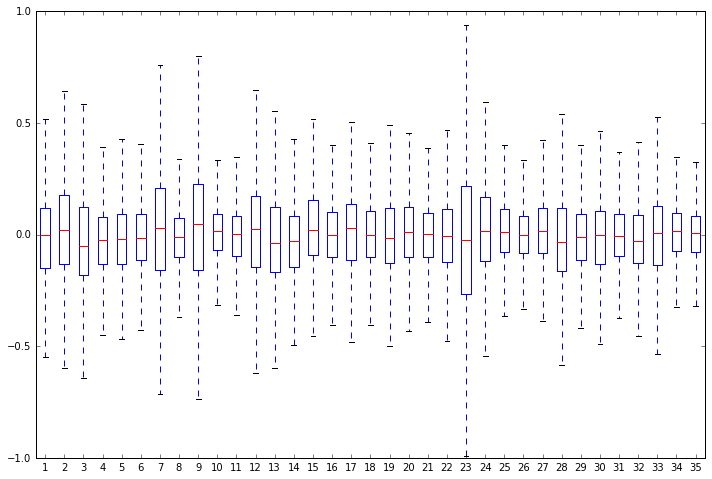

In [141]:
plt.rcParams['figure.figsize'] = (12, 8)

data_to_plot = [[RESIDUALS[:, i]] for i in range(CLEANED.shape[1])]
fig = plt.figure()
plt.boxplot(data_to_plot, showfliers=False)
plt.show()

## y-logged graph of p-values

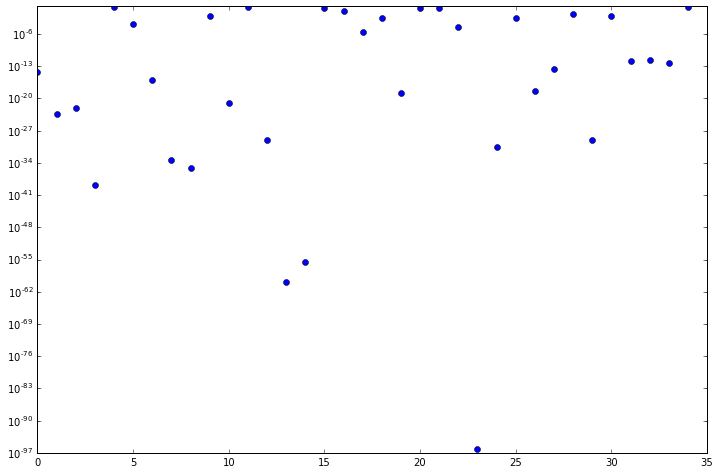

In [142]:
import math
fig = plt.figure()
plt.semilogy(range(len(RESIDUALS_PVALUES)), RESIDUALS_PVALUES, marker="o", lineWidth=0)
plt.show()

# Are ISEs a failure of normalisation?

By failure of normalisation, we mean that either:

1. ISEs are an artifact of slight differences in individual's mean gene expression.
2. ISEs are an artifact of slight differences in variance of individual's gene expression.

There are a few ways to check possibility 1:

1. Are p-values testing for ISEs positively correlated with mean gene expression?
2. Do ISEs disappear when we mean-adjust all the genes?

## First compute mean Gene Expression Level (GEL) for each individual.

In [143]:
CLEANED.shape[1] # this is the number of individuals in the study.
CLEANED.shape[0] # this is the number of genes.

MEAN_GEL = [] # mean gene expression levels, per individual.

for i in range(CLEANED.shape[1]):
    MEAN_GEL.append(sum(CLEANED[...,i])/CLEANED.shape[0])
MEAN_MEAN_GEL = sum(MEAN_GEL)/len(MEAN_GEL)

## Then plot mean expression levels against logged ISEs p-values
1. green line is y=0.05
2. red line is x=`MEAN_MEAN_GEL`, where `MEAN_MEAN_GEL` is a mean expression level of all genes from all individuals.

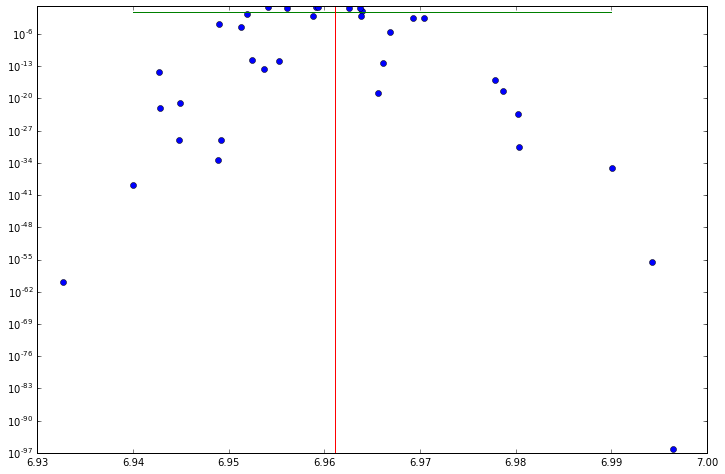

In [144]:

fig = plt.figure()
plt.semilogy(MEAN_GEL, RESIDUALS_PVALUES, marker="o", lineWidth=0)
plt.semilogy([6.94, 6.99], [0.05, 0.05])
plt.semilogy([MEAN_MEAN_GEL]*2, [pow(10, -97), 1])
plt.show()

## And plot mean expression levels against ISEs.

[-0.013935456665220074, 0.017040287567289841, -0.017003227917241986, -0.021937392573411346, 0.00078281609340902984, -0.0057607427767414343, 0.015487530212061298, -0.016400191519639343, 0.026643724723785744, 0.003554578575479131, -0.013215361099444201, 0.00020429397438447431, -0.018467578698052628, -0.026416144604514556, 0.027738593746718936, -0.0010916148963347279, -0.0025603655935914865, 0.0068049669144389585, 0.0047739750708518883, 0.013490809744851355, 0.00095244322519862264, 0.0010146195837047274, -0.010007505257484523, 0.036736920440021532, 0.016269300561427606, 0.0039190457976842428, 0.012928986722654835, -0.012848886138289904, -0.0032486581944021951, -0.017308566846031999, 0.0036862450091910432, -0.010497705179341871, -0.01141539180556074, 0.0094169324971336739, 0.00066871930501607828]


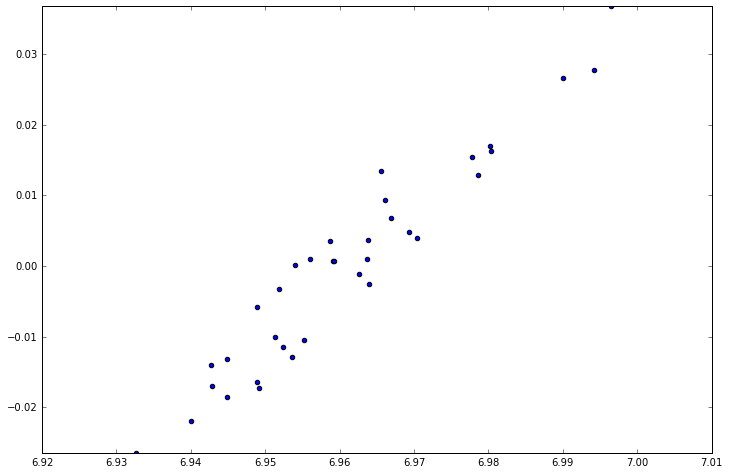

In [145]:
def make_plot_PValues(MEAN_GEL, ISEs):
    fig = plt.figure()
    plt.scatter(MEAN_GEL, ISEs, marker="o")#, lineWidth=0, label="hello"
    print(ISEs)
    plt.ylim([min(ISEs), max(ISEs)])
    plt.show()

make_plot_PValues(MEAN_GEL, ISEs)

### These plots suggest that both existence and value of ISEs depends on the mean GEL in each individual. However, a closer look at the p-values plot suggests that this may not be the entire story -- we still end up with some really small p-values (1/300) -- even very close around the mean.

1. green line is y=0.05
2. red line is x=`MEAN_MEAN_GEL`, where `MEAN_MEAN_GEL` is a mean expression level of all genes from all individuals.

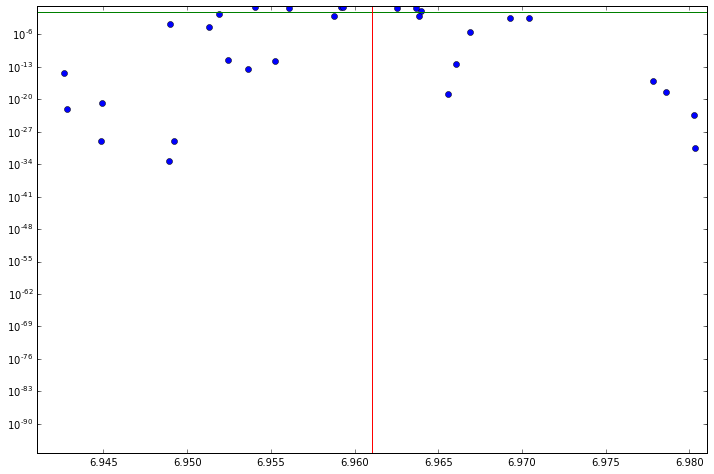

In [150]:
def make_plot_means_vs_PValues(MEAN_MEAN_GEL, RESIDUALS_PVALUES, MEAN_GEL):
    fig = plt.figure()
    xrange = [MEAN_MEAN_GEL - 0.02, MEAN_MEAN_GEL + 0.02]
    yrange = [min(RESIDUALS_PVALUES), 1]
    plt.semilogy(MEAN_GEL, RESIDUALS_PVALUES, marker="o", lineWidth=0)
    plt.semilogy(xrange, [0.05, 0.05])
    plt.semilogy([MEAN_MEAN_GEL]*2, yrange)
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.show()
make_plot_means_vs_PValues(MEAN_MEAN_GEL, RESIDUALS_PVALUES, MEAN_GEL)

## Due to the fact that ISEs are very much mean-sensitive, we should consider whether we can mean-adjust in order to get better results.

In [94]:
# First, compute MEAN_GENE_ADJUSTMENTS

for j in range(CLEANED.shape[1]):
    MEANS.append(sum(CLEANED[:,j])/CLEANED.shape[0])

MEAN_GENE_ADJUSTMENT = []

for k in range(len(MEAN_GEL)):
    MEAN_GENE_ADJUSTMENT.append(MEAN_GEL[k] - MEAN_MEAN_GEL)

print(MEANS[:5])

[6.9426644292038544, 6.9802650197324017, 6.942811148589378, 6.9400084562198048, 6.959168530094475]


In [97]:
# Then, compute ADJUSTED_CLEANED

ADJUSTED_CLEANED = np.copy(CLEANED)
for i in range(CLEANED.shape[0]):
    for j in range(CLEANED.shape[1]):
        ADJUSTED_CLEANED[i][j] -= MEAN_GENE_ADJUSTMENT[j]

adjusted_means = []

for j in range(ADJUSTED_CLEANED.shape[1]):
    adjusted_means.append(sum(ADJUSTED_CLEANED[:,j])/ADJUSTED_CLEANED.shape[0])

## And now we can test how this adjustment influences our data.

In [101]:
ADJUSTED_CLEANED, ADJUSTED_RESIDUALS, ADJUSTED_RESIDUALS_PVALUES, ADJUSTED_MODAL_ALLELE, ADJUSTED_ISEs, ADJUSTED_GENE_PVALUES = numpyAnalysis(ADJUSTED_CLEANED)

[3.6135053374347851e-14, -4.0972339126291036e-14, 8.8420984273508467e-15, -6.1212949206764928e-14, -8.3309852587927791e-16, 2.3724705913529081e-16, -2.7088715472583656e-14, -1.6269309384420235e-14, -4.7122523753913344e-14, 3.9856376090753048e-14, -4.2397253961857827e-14, -1.588346766668035e-14, 5.5028385041021474e-14, 7.0541465641488236e-14, 2.7883076490720798e-14, 6.5584012912403299e-15, 2.6407883598230361e-14, 5.7371257755365163e-15, -2.7204120964398764e-14, -1.302385273968482e-14, 1.2230762796020465e-14, 2.4866978173075269e-14, 3.6460670373019887e-15, -3.5192198576532525e-14, 1.3178661540156381e-14, -3.5373901698785469e-14, -2.1133287700291985e-14, 1.8973288303747627e-14, -2.6249483507978539e-14, -1.7782937147873573e-16, -2.1779457575530181e-14, 2.2214467682003181e-14, 4.0818962806574519e-14, 3.7317737731814607e-15, 1.5789186222055875e-14]


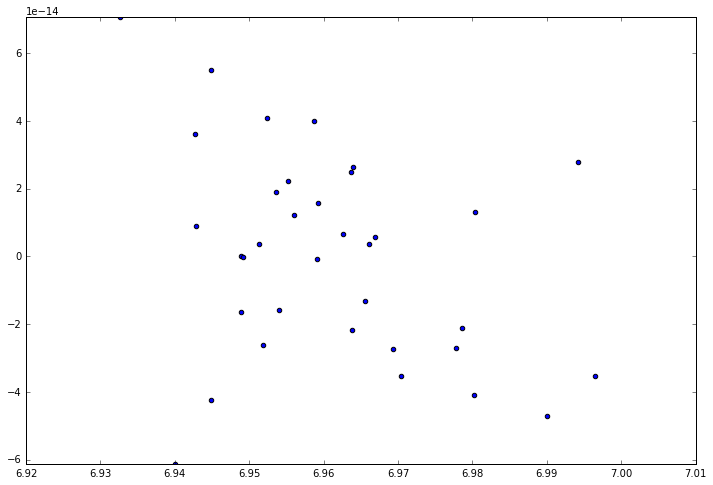

In [153]:
make_plot_PValues(MEAN_GEL, ADJUSTED_ISEs)

As you can see, mean-adjusting the values removes ISEs entirely, i.e. they nearly disappear (they aren't significantly greater than).

## Finally, as this appears to lead to better normalisation, we can mean adjust our data and recompute data-related global variables

In [155]:
CLEANED, RESIDUALS, RESIDUALS_PVALUES, MODAL_ALLELE, ISEs, GENE_PVALUES = ADJUSTED_CLEANED, ADJUSTED_RESIDUALS, ADJUSTED_RESIDUALS_PVALUES, ADJUSTED_MODAL_ALLELE, ADJUSTED_ISEs, ADJUSTED_GENE_PVALUES 

# Gene significance using Benjamini-Hochberg

## first, load transcription cluster ids from `cleaned`

In [156]:
filename = "cleaned"

T_CLUSTER_IDS = []

MAP_T_CLUSTER_INDEX = {}

read = False
with open("cleaned") as f:
    lines = f.readlines()
    i = 0
    for line in lines:
        line = line.rstrip().split("\t")
        if read:
            T_CLUSTER_IDS.append(line[0])
            MAP_T_CLUSTER_INDEX[line[0]] = i
            i += 1
        if line:
            if line[0] == "Affymetrix":
                read = True

assert(len(T_CLUSTER_IDS) == len(GENE_PVALUES))

## Then sort genes in ascending order of GENE_PVALUES

In [157]:
benjhoch = list(zip(GENE_PVALUES, T_CLUSTER_IDS))
benjhoch.sort()

## Then multiply each gene by m/k, where m is the number of hypotheses tested and k = 1, ...,  m

In [158]:
m = len(benjhoch)
k = range(1, len(benjhoch) + 1)
sortedGenes = [((a[0] * m)/(b), a[1]) for a, b in zip(benjhoch, k)]

# unit test for least significat gene
test1 = min(GENE_PVALUES) * m
test2 = sortedGenes[0][0]
assert(abs(test1 - test2) < pow(10, -10))

# unit test for most significat gene
test1 = max(GENE_PVALUES)
test2 = sortedGenes[-1][0]
assert(abs(test1 - test2) < pow(10, -10))

# unit test for least significant gene in a different way

geneID = sortedGenes[0][1]
uncorrected = GENE_PVALUES[MAP_T_CLUSTER_INDEX[geneID]]
assert(uncorrected * m == min(GENE_PVALUES) * m)

# Then answer the question: for any given $\alpha$, where $\alpha$ is the cutoff between $[0, 1]$, how many genes can we detect as significant?

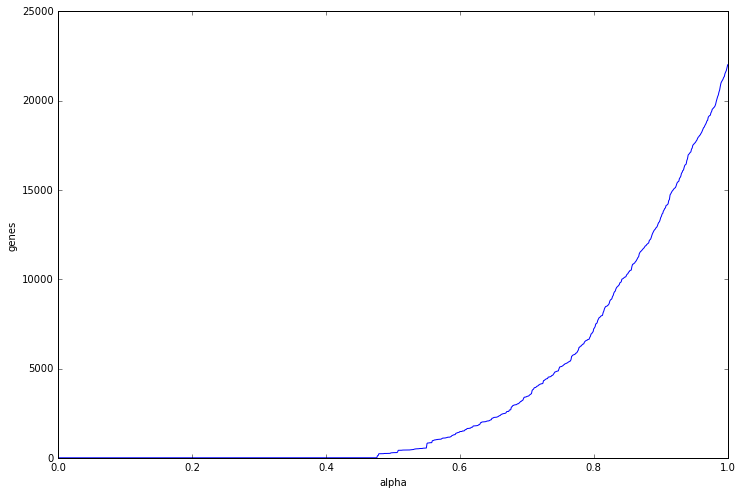

In [159]:
movingMin = sortedGenes[0][0]

alphas = [0.001 * i for i in range(1001)]

def genesForAlpha(sortedGenes, alpha):
    lastGene = -1
    for i, geneTuple in enumerate(sortedGenes):
        significance, geneID = geneTuple
        if significance < alpha:
            lastGene = i
    if lastGene >= 0:
        return sortedGenes[0:lastGene + 1]
    else:
        return []

geneCount = [len(genesForAlpha(sortedGenes, alpha)) for alpha in alphas]

plt.plot(alphas, geneCount)
plt.xlabel("alpha")
plt.ylabel("genes")
plt.show()

## zoom into into the "few genes" region

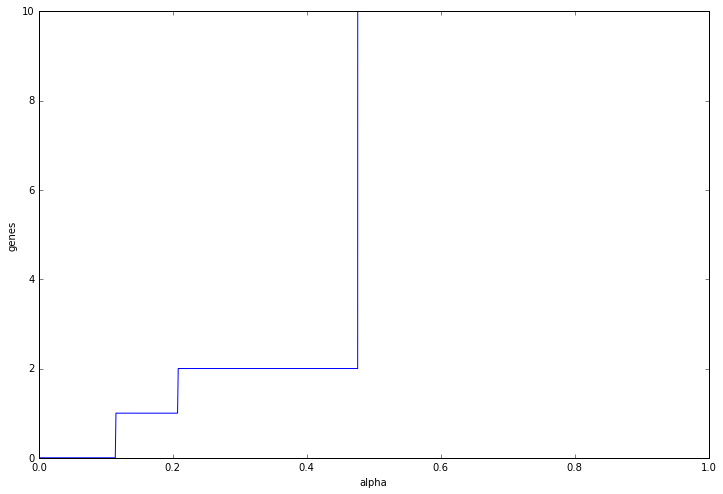

In [160]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(alphas, geneCount)
plt.ylim(0, 10)
plt.xlabel("alpha")
plt.ylabel("genes")
plt.show()

## Or give a list of transcription clusters with FDR of 40%

In [161]:
genesForAlpha(sortedGenes, 0.40)

[(0.1144081991811501, '3139557'), (0.20778466332937209, '2968452')]

## Or give a list of transcription clusters with FDR of 50%

In [163]:
alpha = 0.50
sigGenes = genesForAlpha(sortedGenes, alpha)
noSigGenes = len(sigGenes)
print("number of genes at alpha", alpha, "is", noSigGenes)
print("the 2 genes around the boundary have significance", sortedGenes[noSigGenes - 1][0], sortedGenes[noSigGenes][0])
print("the first 5 genes are")
sigGenes[:5]

number of genes at alpha 0.5 is 284
the 2 genes around the boundary have significance 0.499284326234 0.500232180394
the first 5 genes are


[(0.1144081991811501, '3139557'),
 (0.20778466332937209, '2968452'),
 (0.66525385729766573, '2358393'),
 (0.64537306550438289, '2620894'),
 (0.75235272520269059, '2383894')]

This is strange. Such a sudden raise in detected genes is quite surprising (2 genes vs 803, FDR of 40% vs FDR of 50%). I hope that reviewing the proof of Benjamini-Hochberg for my literature review is going to help me understand why this is allowed to happen (Unless this is a bug in my program, probability is playing around with my intuition).

# Disease Specific Effects

## Let us partition the genes at FDR of 50% into 2 groups randomly. Let us compute the DSE of one group, apply it to the other group and check if it helps improve significance.


In [164]:
# first, partition genes into random groups
import random
random.shuffle(sigGenes)
genesA = sigGenes[:noSigGenes//2]
genesB = sigGenes[noSigGenes//2:]

In [166]:
# unit test our map
test1 = CLEANED[MAP_T_CLUSTER_INDEX["2315554"]][0]
test2 = 7.54562452199732

# No longer true after readjustments
#assert(abs(test1 - test2) <= pow(10, -10))

# compute Disease Specific effects

def computeDSE(CLEANED, RESIDUALS, genesA, genesB):
    DSE = [0] * CLEANED.shape[1]
    relevantGenesAIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesA]
    relevantGenesBIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesB]

    for i in range(CLEANED.shape[1]):
        relevantResiduals = [RESIDUALS[j,i] for j in relevantGenesAIndex]
        DSE[i] = sum(relevantResiduals)/len(relevantResiduals)

    # copy CLEANED into another array
    DSE_ADJUSTED = np.copy(CLEANED)

    # adjust genes in set B with DSEs computed from genes in set A
    for i in relevantGenesBIndex:
        for j in range(CLEANED.shape[1]):
            DSE_ADJUSTED[i][j] -= DSE[j]
    return DSE_ADJUSTED, relevantGenesBIndex

def computeReverseDSE(CLEANED, RESIDUALS, genesA, genesB):
    DSE = [0] * CLEANED.shape[1]
    relevantGenesAIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesA]
    relevantGenesBIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesB]

    for i in range(CLEANED.shape[1]):
        relevantResiduals = [RESIDUALS[j,i] for j in relevantGenesAIndex]
        DSE[i] = sum(relevantResiduals)/len(relevantResiduals)

    # copy CLEANED into another array
    DSE_ADJUSTED = np.copy(CLEANED)

    # adjust genes in set B with DSEs computed from genes in set A
    for i in relevantGenesBIndex:
        for j in range(CLEANED.shape[1]):
            DSE_ADJUSTED[i][j] += DSE[j]
    return DSE_ADJUSTED, relevantGenesBIndex


DSE_ADJUSTED, relevantGenesBIndex = computeDSE(CLEANED, RESIDUALS, genesA, genesB)

## Now, let's repeat the numpy analysis using `DSE_ADJUSTED`

In [167]:
CLEANED_B, RESIDUALS_B, RESIDUALS_PVALUES_B, MODAL_ALLELE_B, ISEs_B, GENE_PVALUES_B = numpyAnalysis(DSE_ADJUSTED)

## Now, let's count in how many cases the p-values have improved

In [168]:
#print(relevantGenesBIndex)

def fractionImprovedPValues(GENE_PVALUES, GENE_PVALUES_B, relevantGenesBIndex):
    previousPValues = [GENE_PVALUES[i] for i in relevantGenesBIndex]
    currentPValues = [GENE_PVALUES_B[i] for i in relevantGenesBIndex]
    countSmaller = 0
    for i, _ in enumerate(relevantGenesBIndex):
        if (currentPValues[i] < previousPValues[i]):
            countSmaller += 1
    return countSmaller/len(currentPValues)

fractionImproved = fractionImprovedPValues(GENE_PVALUES, GENE_PVALUES_B, relevantGenesBIndex)

print("P-values have improved in", fractionImproved, "fraction of cases")
print("P-values have worsened in", 1 - fractionImproved, "fraction of cases")

P-values have improved in 0.4154929577464789 fraction of cases
P-values have worsened in 0.5845070422535211 fraction of cases


The values printed in the previous cells are random and determined by a particular random seed, but from running it a couple of times I've seen both fractions to be rather similar.

# Progress Report 08/12/2016

## Biopython

I have written a parser, which allows one to access raw probe data from the Affymetrix CEL files version 4 (which is what we're working with). My work gained interest of a large open-source bioinformatics package called Biopython. I discussed contributing this parser to Biopython with the maintainer of this package, Peter Cock.

After very scrupulous code review, writing a lot of unit testing, clearing out all of Peter's doubts about the code, and fixing multiple issues in the code, primarly to do with error handling, my contribution has been accepted into the project, and will be available as of the next release (whenever that happens). This is the link to the contribution:

https://github.com/biopython/biopython/commit/6c14a26dda32ad6d3147036a01f3d0c4d306c647

And the dicussion, which I and Peter Cock had about it:

issue tracker:

https://github.com/biopython/biopython/issues/1008

pull request:

https://github.com/biopython/biopython/pull/1011

There are a number benefits to this contribution of both political and scientific value.

Political:

- If we discover any new interesting pipeline we will find it much easier to distribute it as part of biopython (as opposed to distributing it ourselves).
- We're doing a good service to the community.

Scientific:

1. We can now easily detect/fix some of the issue with our data:

 - Aren't all of our probes oversaturated/ undersaturated?
 - How do we know if a probe is broken (or there is a scratch on the microarray)?
 - RMA doesn't normalise means, can we write our own better-RMA?

2. We get an extra pair of eyeballs on the code, which should make it less buggy.

What the parser gives us is ~5.5 million of triplets of
the form:

(double, double, integer)

The last number is the number of pixels per probe from which an
intensity measurement was taken. This is always 9.

The first number is the average intensity of these pixels.

The middle number is the standard deviation.

The following are the first few triplets:

    (7326.0, 875.0999755859375,  9)
    (162.0,  34.099998474121094, 9)
    (6933.0, 1001.0,             9)
    (224.0,  36.400001525878906, 9)
    (54.0,   6.0,                9)
    (247.0,  23.5,               9)
    (210.0,  18.299999237060547, 9)

## Literature Review

I've started writing the literature review (the deadline is 16th of January). That's also attached. 

## Comparing my list of genes with John's.

There are 3 approaches to this analysis:

Mine:
1. Use RMA + standard linear regression (Adam1)
2. Use RMA + Limma (Adam2)

John's:
1. Use DChip + Limma (John1)

I make a pair-wise comparison of them looking at top 10 results:
1. (Adam1 vs John1)
2. (Adam1 vs Adam2)
3. (Adam2 vs John1)

## Wilf's results

I've re-read Wilf's report and tried to compare his analysis to mine, and which bits are missing.

As Darren pointed out, Wilf considered a few measures of DSEs, in both blood and muscle:

- Bl-GSE -- Genome-Wide Specific effect.
- Bl-DSE-100 -- Disease Specific effect for the top 100 genes.
- Bl-DSE-800 -- Disease Specific effect for the top 800 genes.
- Bl-DSE-101-800 -- Disease Specific effect for the top 800 genes excluding top 100 genes.
- Bl-GSE-DSE-800 -- I don't get that one. maybe average of the two?

For muscle, replace "Bl" with "M".

He then produced a graph like this:

![Wilf DSEs](WilfISEs.jpg)

I'm trying to reproduce this result using my approach.

# Comparing my list of genes with John's.

## (Adam1, John1)

In [169]:
# The following genes are the 10 most significant genes in blood I have identified using regular regression:
sortedGenes[:10]

[(0.1144081991811501, '3139557'),
 (0.20778466332937209, '2968452'),
 (0.66525385729766573, '2358393'),
 (0.64537306550438289, '2620894'),
 (0.75235272520269059, '2383894'),
 (0.71638961268198809, '2411799'),
 (0.75356948656595113, '2677624'),
 (0.66597460012216214, '3470372'),
 (0.5966077809240995, '2968373'),
 (0.56375924387095344, '3211579')]

In [170]:
# Let us load in the genes, which John identified as significant in his
# analysis using Limma.
def loadLimma(filename):
    JohnsGenes = []
    with open(filename) as f:
        lines = f.readlines()
        for lineI, line in enumerate(lines):
            line = line.rstrip().split(" ")
            line = [i.strip('"') for i in line]
            if lineI == 0:
                if "ID" not in line:
                    line = ["ID"] + line
                IDIndex = line.index("ID")
                PValue = line.index("adj.P.Val")
            else:
                gene = (line[IDIndex], float(line[PValue]))
                JohnsGenes.append(gene)
    return JohnsGenes

def loadLimmaPValue(filename):
    JohnsGenes = []
    with open(filename) as f:
        lines = f.readlines()
        for lineI, line in enumerate(lines):
            line = line.rstrip().split(" ")
            line = [i.strip('"') for i in line]
            if lineI == 0:
                if "ID" not in line:
                    line = ["ID"] + line
                IDIndex = line.index("ID")
                PValue = line.index("P.Value")
            else:
                gene = (line[IDIndex], float(line[PValue]))
                JohnsGenes.append(gene)
    return JohnsGenes

# Interestingly, Limma reports John's genes to be more significant than mine
# (although arguably the comparison isn't apples-to-apples, because John is
# choosing his genes from ~40k as opposed to from ~20k, so values should be
# adjusted using a different, ~2 times larger constant).
JohnsGenes = loadLimma("JohnsGenes.csv")
JohnsGenes

[('1559735_at', 0.0549157815120137),
 ('239362_at', 0.0629671616442373),
 ('234406_at', 0.222582913167388),
 ('216018_at', 0.222582913167388),
 ('212826_s_at', 0.231350259419169),
 ('226071_at', 0.231350259419169),
 ('216256_at', 0.231350259419169),
 ('216255_s_at', 0.231350259419169),
 ('212876_at', 0.231350259419169),
 ('218706_s_at', 0.231350259419169)]

### Let us load into memory a (1:many) mapping from u133 IDs to HuEx transcription cluster IDs (I took the file from Ralf Krahe).

In [171]:
with open(CEL_MAPPING) as f:
    result = 10
    lines = f.readlines()
    u133Map = {}
    for line in lines:
        line = line.strip().split("\t")
        u133Map[line[0]] = line[1].split()

In [172]:
# Check to how many HuEx IDs John's IDs actually map

from itertools import chain

JohnsGenesIDs = [geneTuple[0] for geneTuple in JohnsGenes]

#for geneID in JohnsGenesIDs:
#    print(geneID)

unflattenedIDs = [u133Map[geneID] for geneID in JohnsGenesIDs]
IDs = chain.from_iterable(unflattenedIDs)
IDs = [i for i in IDs]

In [173]:
print("This is how many John's IDs we have:")
print(len(JohnsGenesIDs))
print("This is how many HuEx IDs we get from John's IDs:")
print(len(IDs))

This is how many John's IDs we have:
10
This is how many HuEx IDs we get from John's IDs:
55


### As can be seen in the previous cell, we have 55 HuEx IDs from 10 U133 IDs.

In [174]:
myGenes = set(i[1] for i in sortedGenes[:10])
johnsGenes = set(IDs)
print(myGenes)
print(johnsGenes)

# unit test semantics
setA = set(["123"])
setB = set(["234", "123"])
assert([i for i in setA.intersection(setB)][0] == "123")

{'3211579', '2411799', '2358393', '2968452', '2677624', '3470372', '2620894', '2383894', '3139557', '2968373'}
{'46287', '1154697', '910072', '213075', '73419', '864057', '782227', '649736', '1402282', '445811', '954374', '963886', '1141866', '1063265', '387321', '534354', '28334', '1018667', '337539', '1244871', '45027', '418215', '894974', '867868', '1167340', '36953', '290659', '1342298', '698420', '529255', '530482', '486626', '157605', '580511', '915881', '81537', '873115', '1280817', '435375', '651452', '185872', '378441', '1261220', '292318', '69873', '1328643', '1206820', '833732', '677792', '125039', '343953', '619391', '763493'}


In [175]:
myGenes.intersection(johnsGenes)

set()

### Unfortunately, my analysis and John's analysis entirely disagree on the top 10 genes (transcription clusters).

There are various possibilities as to why that is:
1. We normalised in a different way.
2. The mapping from U133 probesets to HuEx transcription clusters is inaccurate.
2. Limma is significantly different from standard linear regression. We can check that by keeping normalisation the same and changing the linear model, i.e. (Adam1, Adam2).

## (Adam1, Adam2)

In [176]:
# let us first run Limma on RMA-normalised `cleaned`.
utils.executeNotebook("analyseLimma.ipynb", ".")

In [177]:
Adam2Genes = loadLimma("cleanedLimma")
Adam2GenesPValue = loadLimmaPValue("cleanedLimma")

In [180]:
print("The most significant 10 genes")
print(Adam2Genes[:10])
print(JohnsGenes[:10])
[adam[1]/john[1] for adam, john in zip(Adam2Genes[:10], JohnsGenes[:10])]

The most significant 10 genes
[('X3139557', 0.106701847574654), ('X2968452', 0.106701847574654), ('X2358393', 0.417830124115676), ('X2383894', 0.418094858060729), ('X2968373', 0.418094858060729), ('X3470372', 0.418094858060729), ('X2620894', 0.418094858060729), ('X2677624', 0.418094858060729), ('X2968387', 0.418094858060729), ('X2905404', 0.418094858060729)]
[('1559735_at', 0.0549157815120137), ('239362_at', 0.0629671616442373), ('234406_at', 0.222582913167388), ('216018_at', 0.222582913167388), ('212826_s_at', 0.231350259419169), ('226071_at', 0.231350259419169), ('216256_at', 0.231350259419169), ('216255_s_at', 0.231350259419169), ('212876_at', 0.231350259419169), ('218706_s_at', 0.231350259419169)]


[1.9430088152585294,
 1.694563400801142,
 1.8771886762100967,
 1.8783780484816957,
 1.8071942478491418,
 1.8071942478491418,
 1.8071942478491418,
 1.8071942478491418,
 1.8071942478491418,
 1.8071942478491418]

In [181]:
print("The least significant 10 genes")
Adam2Genes[-10:]

The least significant 10 genes


[('X3225398', 0.999891055401644),
 ('X2777412', 0.999891055401644),
 ('X4019849', 0.999891055401644),
 ('X3825154', 0.999891055401644),
 ('X2639054', 0.999891055401644),
 ('X3980903', 0.999891055401644),
 ('X3167684', 0.999915006828432),
 ('X3456081', 0.99995681345024),
 ('X3453506', 0.99995681345024),
 ('X3740646', 0.99995681345024)]

### This is as expected.

On a separate note, the author of limma, Gordon Smyth, argues that p-values are not suitable measure of significance in genomic analysis. He prefers "fold changes", but I haven't yet understood his argumentation:
http://www.slideshare.net/AustralianBioinformatics/the-value-of-p-values-gordon-smyth

In [182]:
# Let us now check how many of these genes actually agree.

removeX = [geneID[1:] for geneID, pValue in Adam2Genes[:10]]

In [183]:
myGenes2 = set(removeX)
len(myGenes2.intersection(myGenes))

8

### As expected, we see 8/10 genes in common.

## Finally, we can compute (Adam2, John1)

In [184]:
print(myGenes2)

{'2358393', '2968452', '2677624', '3470372', '2620894', '2383894', '2905404', '3139557', '2968387', '2968373'}


In [185]:
print(johnsGenes)

{'46287', '1154697', '910072', '213075', '73419', '864057', '782227', '649736', '1402282', '445811', '954374', '963886', '1141866', '1063265', '387321', '534354', '28334', '1018667', '337539', '1244871', '45027', '418215', '894974', '867868', '1167340', '36953', '290659', '1342298', '698420', '529255', '530482', '486626', '157605', '580511', '915881', '81537', '873115', '1280817', '435375', '651452', '185872', '378441', '1261220', '292318', '69873', '1328643', '1206820', '833732', '677792', '125039', '343953', '619391', '763493'}


In [186]:
myGenes2.intersection(johnsGenes)

set()

## To sum up, pair-wise intersection of the sets of top 10 genes in the analyses, is of the following sizes:
- (Adam1, John1) - 0 
- (Adam1, Adam2) - 8
- (Adam2, John1) - 0

Where:
- Adam1 is RMA + linear regression
- Adam2 is RMA + limma
- John is DChip + limma

# Reproducing Wilf's results

In [216]:
# We need to compute the following results

# Bl_GSE
# Bl_DSE_100
# Bl_DSE_800
# Bl_DSE_101_800

import random
random.shuffle(sigGenes)
allGenes = [gene for pValue, gene in sortedGenes]

top100Genes = allGenes[:100]
top800Genes = allGenes[:800]
top101to800Genes = allGenes[100:800]

test1 = CLEANED[MAP_T_CLUSTER_INDEX["2315554"]][0]
test2 = 7.54562452199732
#assert(abs(test1 - test2) <= pow(10, -10))
DSE_DATA = None
def dataForWilfsGraph(DSEGenes):
    global DSE_DATA
    # compute Disease Specific effects
    DSE = [0] * CLEANED.shape[1]
    relevantGenes = [MAP_T_CLUSTER_INDEX[t_cluster_id] for t_cluster_id in DSEGenes]
    otherGenes = [MAP_T_CLUSTER_INDEX[t_cluster_id] for t_cluster_id in allGenes]
    
    for i in range(CLEANED.shape[1]):
        relevantResiduals = [RESIDUALS[j,i] for j in relevantGenes]
        DSE[i] = sum(relevantResiduals) / len(relevantResiduals)
    DSE_DATA = DSE
    # copy CLEANED into another array
    DSE_ADJUSTED = np.copy(CLEANED)
    
    # adjust *all* genes
    for i in otherGenes:
        for j in range(CLEANED.shape[1]):
            DSE_ADJUSTED[i][j] -= DSE[j]
    
    # now, let's repeat the previous analysis
    CLEANED_B, RESIDUALS_B, RESIDUALS_PVALUES_B, MODAL_ALLELE_B, ISEs_B, GENE_PVALUES_B = numpyAnalysis(DSE_ADJUSTED)
    return sorted(GENE_PVALUES_B)

#judge = [0.2, 0.3,  0.5,  0.6, 0.65, 0.68]
#victim = [0.1, 0.15, 0.25, 0.5, 0.55, 0.7]

def nplot(judgeStream, victimStream):
    judgeIter = 0
    victimIter = 0
    
    assert(len(judgeStream) == len(victimStream))
    
    end = len(judgeStream)
    nextJudge  = judgeStream[judgeIter]
    nextVictim = victimStream[victimIter]
    
    output = []
    while True:
        currentJudge = nextJudge
        currentVictim = nextVictim
        if currentVictim <= currentJudge:
            victimIter += 1
        else:
            output.append(victimIter)
            judgeIter += 1
        try:
            nextJudge = judgeStream[judgeIter]
            nextVictim = victimStream[victimIter]
        except IndexError:
            break
    return output

sortedPValues = sorted(GENE_PVALUES)
def showResult(genesForDSE):
    return nplot(sortedPValues, dataForWilfsGraph(genesForDSE))

In [217]:
Bl_DSE_100 = showResult(top100Genes)

In [190]:
Bl_DSE_800 = showResult(top800Genes)

In [191]:
Bl_DSE_101_800 = showResult(top101to800Genes)

In [192]:
NEW_PVALUES = dataForWilfsGraph(top100Genes)

## Finally, we can simulate Wilf's plots -- we zoom into the region of 25000, 100 and 100 genes.

In [193]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

def makeWilfsPlot(ran):
    plt.plot(Bl_DSE_100, label="Bl_DSE_100")
    plt.plot(Bl_DSE_800, label="Bl_DSE_800")
    plt.plot(Bl_DSE_101_800, label="Bl_DSE_101_800")
    plt.plot(range(len(Bl_DSE_100)), label="unchanged")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.xlim(0, ran)
    plt.ylim(0, ran)
    plt.show()


## First, let's have a look at a whole

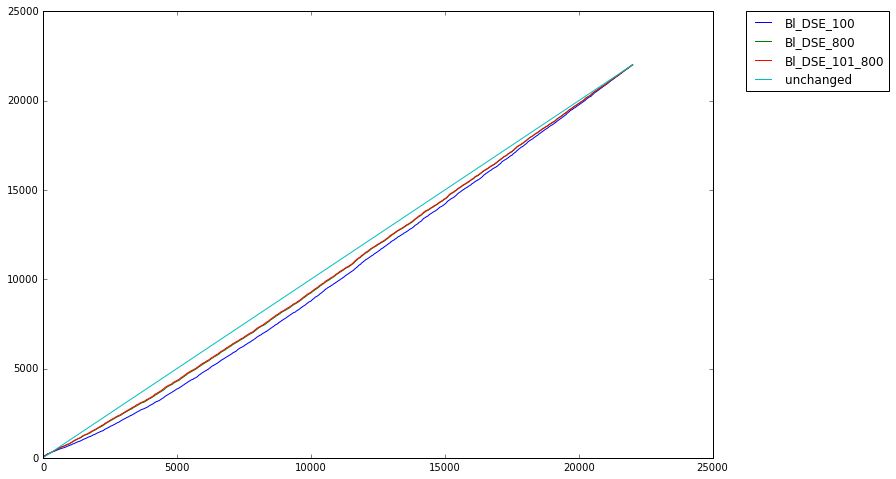

In [219]:
makeWilfsPlot(25000)

## Then, let's zoom in really close

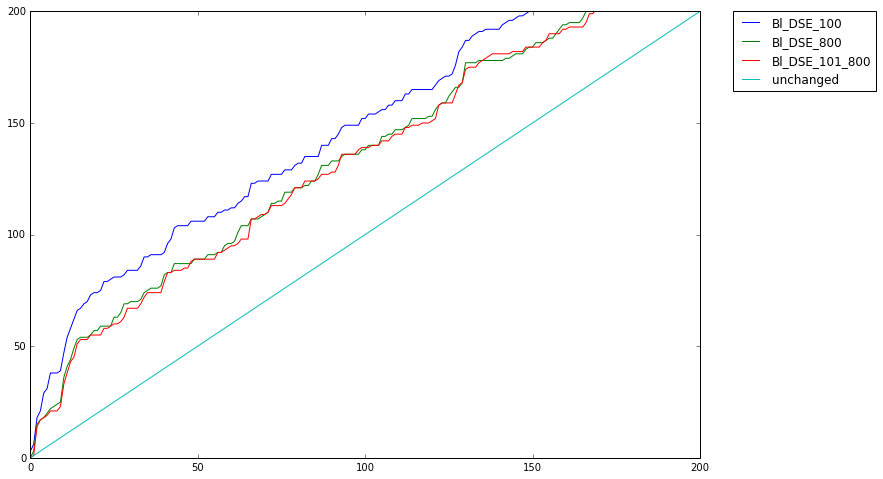

In [220]:
makeWilfsPlot(200)

## Then, let's zoom in at the level Wilf zoomed in

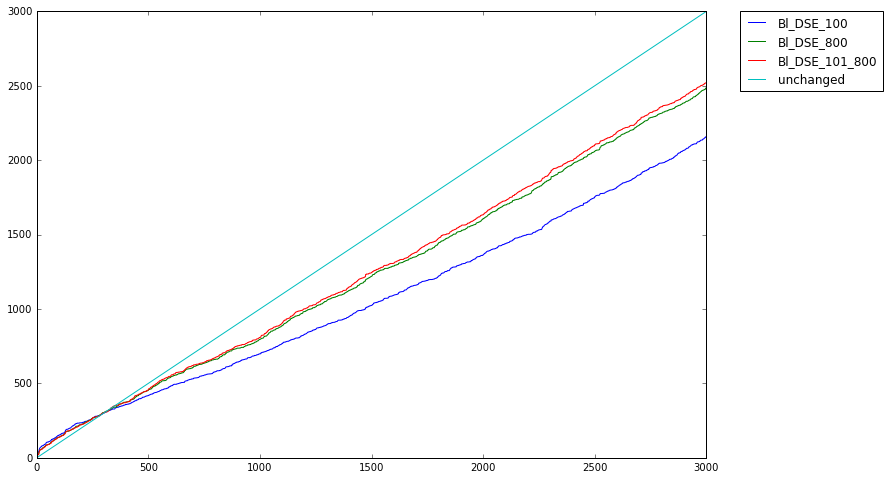

In [221]:
makeWilfsPlot(3000)

## For easy reference, here's Wilf's plot repeated:

![Wilf DSEs](WilfISEs.jpg)

# Progress Report 17/01/2017

## Analysis in Limma is fixed

Before the winter break, John and I have managed to fix the broken analysis in Limma. We are now getting comparable results using Limma and least-square linear regression.

## Literature review

After the winter break I've finished off the literature review, which I attach as a separate file.

## Raw individual probe data of probes in probe sets

I've now got 2 programs:
 - AlternativeSplicingMD, which can pull out individual probe data about a gene or a group of genes (e.g. Cardiac Troponin 2, TNNT2)
 - AlternativeSplicingMDVisualisation, which can plot that individual probe data against modal allele length.

This enables the following manual process:
 1. Identify list of interesting alternative splicing events from literature and write down the corresponding gene IDs (i.e. TNNT2).
 2. Go to http://grch37.ensembl.org/ and set it up so that it shows data about our chip (HuEx_st2) and mRNA transcripts.
 3. Identify interesting exon and a corresponding probeset.
 4. Plot intensities of all probes against modal allele length.
 5. Verify the sensibility of probe choices with the help of Blast (I and John had some problems with it, but I managed to sort them out).

Going through this manual process, I've made a few realizations:

1. Probe intesity data across probesets varies wildly. But it's very consistent across probes belonging to a single probest. 
2. The transcription clusters, which were reported to us by limma and LSR do not look at all significant at the probe level. What they do look like, is as if they belonged to a group of transcription clusters with very few probesets -> very few probes. This could be expected, because there is heuristic argument to be made, that transcription clusters with fewer probes are more likely to be found significant by random chance. It doesn't look like RMA + Limma or RMA + LSR take this into account.
3. In Human Exon Array, the type of microarray we're working with, each probeset contains between 1 - 4 probes targeting a sliver of a transcription cluster. This sliver may correspond to an exon, but not all exons are covered. For example the fifth mini-exon of Cardiac Troponin 2, which is of interest in MD due to reported alternative splicing is not covered.

I attach 2 notebooks as separate files:

1. AlternativeSplicingMD.ipynb
2. AlternativeSplicingMDVisualisation.ipynb

But I think reading them is not going to be as valuable as seeing the demo of the manual process.

## Checking if $DSE_{100}$ exists

I take 200 most significant genes and compute $DSE_{100}$ for 100 random genes and apply it as a correction to the rest of the genes.


# Comparing P-values between Limma (now fixed and working) and regular regression

## False Discovery rates (adjusted p-values) in Limma (x-axis) vs linear regression (y-axis).

Why is there a vertical line around 0.4?

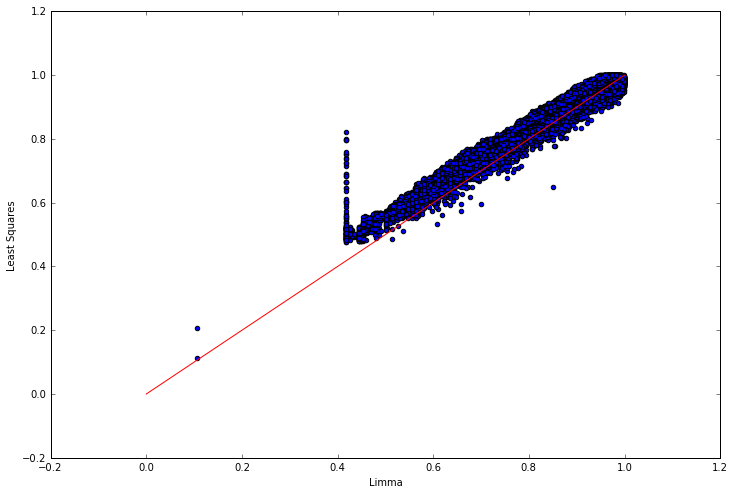

In [200]:
idsToPairs = {}

for id, gene in Adam2Genes:
    idsToPairs[id[1:]] = [gene]

for gene, id in sortedGenes:
    idsToPairs[id].append(gene)

pValuesLimma = [pValues[0] for key, pValues in idsToPairs.items()]
pValuesLSR = [pValues[1] for key, pValues in idsToPairs.items()]

f = plt.figure()
ax = f.add_subplot(111)
plt.scatter(pValuesLimma, pValuesLSR)
plt.plot([0,1], [0,1], 'r-')
ax.set_xlabel("Limma")
ax.set_ylabel("Least Squares")

#sortedGenes[:10]

## P-values (non-adjusted) in Limma (x-axis) vs linear regression (y-axis). Full range.

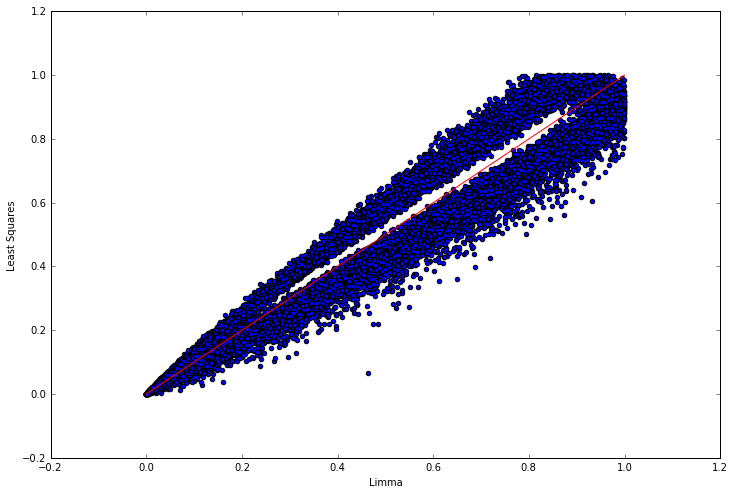

In [201]:
for id, gene in Adam2GenesPValue:
    idsToPairs[id[1:]] = [gene]

for gene, id in benjhoch:
    idsToPairs[id].append(gene)

idsToPairs

unadjustedPValuesLimma = [pValues[0] for key, pValues in idsToPairs.items()]
unadjustedPValuesLCS = [pValues[1] for key, pValues in idsToPairs.items()]

f = plt.figure()
ax = f.add_subplot(111)

plt.scatter(unadjustedPValuesLimma, unadjustedPValuesLCS)
plt.plot([0,1], [0,1], 'r-')

ax.set_xlabel("Limma")
ax.set_ylabel("Least Squares")

#sortedGenes[:10]

## P-values (non-adjusted) in Limma (x-axis) vs linear regression (y-axis). Zoom level at 0.01

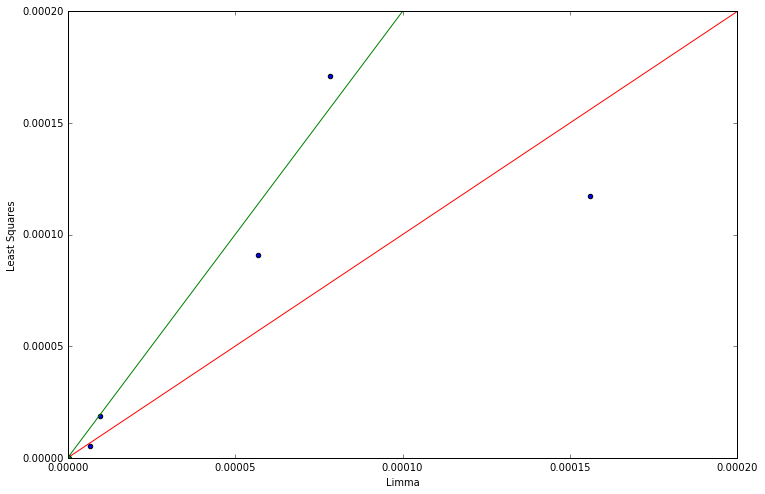

In [203]:
f = plt.figure()
ax = f.add_subplot(111)

plt.scatter(unadjustedPValuesLimma, unadjustedPValuesLCS)

plt.plot([0,1], [0,1], 'ro-')
plt.plot([0,1], [0,2], 'go-')
limits = [0, 0.0002]

plt.xlim(limits)
plt.ylim(limits)

ax.set_xlabel("Limma")
ax.set_ylabel("Least Squares")

Red line is the identity. Green line grows 2 times faster than the identity (red line). Blue points between the red line and the green line have p-values up to 2x smaller with limma than with least square regression.

# Progress Report 29.01.2017

## ISEs

I've followed up on the work I did a few weeks ago, and I renormalised our data using "mean-adjusted RMA". This normalisation procedure works as follows:

- Do the RMA.
- Compute individual's average expression level $MEAN\_GEL_{i}$ and average expression level of all individuals $MEAN\_MEAN\_GEL$.
- For each individual modify each gene by removing a correction factor $MEAN\_MEAN\_GEL - MEAN\_GEL_{i}$

This gives data, where each individual has equal value of mean gene expression.

Under this normalisation ISEs dissapear, i.e. are no longer significant, nor have a big numeric value (only about $10^{-14}$), many orders of magnitude less than the measurement error.

However, DSEs still exist, although the more genes we take, the closer to 0 the DSE will be.

## Other improvements of "mean adjusted RMA"

I have re-run all experiments/analyses up to date (fixing any issues, which arised) and I've noticed two interesting things:

- Our new normalisation method seems to help very much (by a factor of 2) with gene significance. Although previous methods gave p-values of 20% earlier on, now we get 10%.
- Our new normalisation method seems to remove many genes from the "mildly significant" region of p-values < 0.5, 284 genes vs 803.

## More expriments

I've written a small framework for running expriments. The framework caches all experiments on hard drive, with meaningful filenames, so that I can switch off my computer without loosing 2+ hours of CPU time, and import the results into other programs.

I test for biological significance of DSEs by taking 2n of the most significant genes and then splitting them into lower n for computing DSEs and higher n for computing the p-values. The results are again negative.


# Checking if $DSE_{200}$ exists

## First, let us build a little framework to run experiments in.

In [ ]:
EXPERIMENTS = "cache"

In [225]:
import time, pickle
import os, os.path
from contextlib import *

experimentsDir = "experiments"

if not os.path.exists(experimentsDir):
    os.makedirs(experimentsDir)


@contextmanager
def errorOpener(filename, mode="r"):
    try:
        f = open(filename, mode)
    except FileNotFoundError as err:
        yield None, err
    else:
        try:
            yield f, None
        finally:
            f.close()

def canonicalForm(function, kwargs):
    kwargsToSort = list((a, b) for a, b in kwargs.items())
    kwargsToSort.sort()
    kwargsCanonical = ",".join(str(a) + ":" + str(b) for a, b in kwargsToSort)
    filePath = "=".join([function.__name__, kwargsCanonical])
    return os.path.join(experimentsDir, filePath)

def exampleExperiment(name="Adam", surname="Kurkiewicz"):
    return "happy days"

def runExperiment(function, **kwargs):
    took = 0
    canonicalPath = canonicalForm(function, kwargs)
    emptyResult = {"result" : None, "took" : 0}
    if EXPERIMENTS == "full":
        print("Running experiment", function.__name__, "with parameters: kwargs=", kwargs, ". It may take some time. The result will be cached in", canonicalPath)
        start = time.time()
        call_result = function(**kwargs)
        stop = time.time()
        took = stop - start
        print("The experiment took", took, "seconds")
        result = {"result": call_result, "took": took}
        with open(canonicalPath, "wb") as f:
            print(result)
            pickle.dump(result, f)
        return result
    elif EXPERIMENTS == "cache":
        with errorOpener(canonicalPath, "rb") as (f, err):
            if err:
                print(FileNotFoundError("Can't find the experiment " +  canonicalPath + " consider passing EXPERIMENTS=\"full\""))
                return emptyResult
            else:
                return pickle.load(f)
    else:
        print("In order to run this experiment, please pass either EXPERIMENTS=\"cache\" or EXPERIMENTS=\"full\" to the kernel, and rerun relevant cells.")
        return emptyResult

runExperiment(exampleExperiment, name="Iva", surname="Babukova")

Running experiment exampleExperiment with parameters: kwargs= {'surname': 'Babukova', 'name': 'Iva'} . It may take some time. The result will be cached in experiments/exampleExperiment=name:Iva,surname:Babukova
The experiment took 1.1920928955078125e-06 seconds
{'result': 'happy days', 'took': 1.1920928955078125e-06}


{'result': 'happy days', 'took': 1.1920928955078125e-06}

In [229]:
def DSE_check(noGenes = 200, numberOfAnalyses = 100, randomise=True):
    improved = []
    for i in range(numberOfAnalyses):
        sigGenes = benjhoch[:noGenes]
        if randomise:
            random.shuffle(sigGenes)
        genesA = sigGenes[:noGenes//2]
        genesB = sigGenes[noGenes//2:]
        DSE_ADJUSTED, relevantGenesBIndex = computeDSE(CLEANED, RESIDUALS, genesA, genesB)
        CLEANED_B, RESIDUALS_B, RESIDUALS_PVALUES_B, MODAL_ALLELE_B, ISEs_B, GENE_PVALUES_B = numpyAnalysis(DSE_ADJUSTED)
        fractionImproved = fractionImprovedPValues(GENE_PVALUES, GENE_PVALUES_B, relevantGenesBIndex)
        improved.append(fractionImproved)
    return improved

In [233]:
r = runExperiment(DSE_check, noGenes=200, numberOfAnalyses=100)
IMPROVED = r['result']
TOOK = r['took']

Running experiment DSE_check with parameters: kwargs= {'numberOfAnalyses': 100, 'noGenes': 200} . It may take some time. The result will be cached in experiments/DSE_check=noGenes:200,numberOfAnalyses:100
The experiment took 2027.3047678470612 seconds
{'result': [0.47, 0.35, 0.41, 0.44, 0.34, 0.29, 0.41, 0.41, 0.37, 0.35, 0.38, 0.38, 0.37, 0.3, 0.4, 0.37, 0.38, 0.39, 0.37, 0.39, 0.42, 0.34, 0.35, 0.31, 0.37, 0.38, 0.37, 0.38, 0.28, 0.37, 0.4, 0.38, 0.33, 0.34, 0.36, 0.42, 0.39, 0.36, 0.38, 0.35, 0.52, 0.38, 0.48, 0.38, 0.31, 0.34, 0.37, 0.38, 0.34, 0.29, 0.47, 0.33, 0.4, 0.42, 0.46, 0.36, 0.4, 0.42, 0.37, 0.34, 0.45, 0.44, 0.35, 0.41, 0.46, 0.37, 0.63, 0.34, 0.4, 0.34, 0.38, 0.34, 0.36, 0.42, 0.37, 0.33, 0.44, 0.46, 0.44, 0.36, 0.43, 0.38, 0.38, 0.4, 0.39, 0.31, 0.43, 0.41, 0.37, 0.38, 0.35, 0.35, 0.35, 0.36, 0.35, 0.41, 0.36, 0.42, 0.37, 0.39], 'took': 2027.3047678470612}


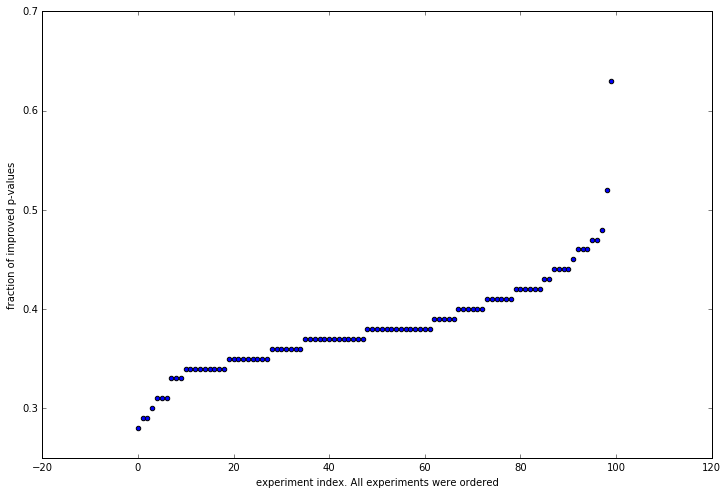

In [234]:
if IMPROVED:
    f = plt.figure()
    ax = f.add_subplot(111)
    fig = ax.scatter(range(len(IMPROVED)), sorted(IMPROVED))
    ax.set_ylabel("fraction of improved p-values")
    ax.set_xlabel("experiment index. All experiments were ordered")

# Run Experiments in a more similar manner to Wilf, i.e. take first n and adjust the next n. Take n between 0 and 100.

In [235]:
results = []
genes = []

n = 100

for geneNo in range(2, 2 * n + 2, 2):
    r = runExperiment(DSE_check, noGenes=geneNo, numberOfAnalyses=1, randomise=False)
    results.append(r["result"][0])
    genes.append(geneNo)

Running experiment DSE_check with parameters: kwargs= {'numberOfAnalyses': 1, 'randomise': False, 'noGenes': 2} . It may take some time. The result will be cached in experiments/DSE_check=noGenes:2,numberOfAnalyses:1,randomise:False
The experiment took 20.55731177330017 seconds
{'result': [0.0], 'took': 20.55731177330017}
Running experiment DSE_check with parameters: kwargs= {'numberOfAnalyses': 1, 'randomise': False, 'noGenes': 4} . It may take some time. The result will be cached in experiments/DSE_check=noGenes:4,numberOfAnalyses:1,randomise:False
The experiment took 21.46176052093506 seconds
{'result': [0.0], 'took': 21.46176052093506}
Running experiment DSE_check with parameters: kwargs= {'numberOfAnalyses': 1, 'randomise': False, 'noGenes': 6} . It may take some time. The result will be cached in experiments/DSE_check=noGenes:6,numberOfAnalyses:1,randomise:False
The experiment took 21.058876037597656 seconds
{'result': [0.3333333333333333], 'took': 21.058876037597656}
Running exp

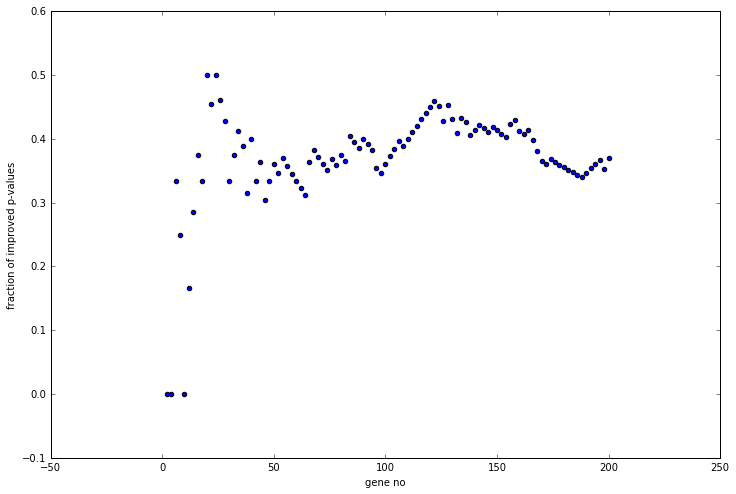

In [236]:
if results:
    f = plt.figure()
    ax = f.add_subplot(111)
    fig = ax.scatter(genes, results)
    ax.set_ylabel("fraction of improved p-values")
    ax.set_xlabel("gene no")

In [237]:
EXPERIMENTS = "cache"

In [239]:
EXPERIMENTS = "full"

1. run for up to 500 "Wilf's style"
2. GSEs + correction.